In [ ]:
import os
import glob
from PIL import Image
import numpy as np

image_dir = '/content/drive/MyDrive/fashion_dataset/jpeg_images/IMAGES'
mask_dir = '/content/drive/MyDrive/fashion_dataset/jpeg_masks/MASKS'

In [ ]:
count = len(os.listdir(image_dir))

In [ ]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
#MASK_CHANNELS = 58

X_train = np.zeros((count, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype = np.uint8)
y_train = np.zeros((count, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype = np.bool)


<ipython-input-51-6099a2873c2a>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((count, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype = np.bool)


In [ ]:
path = os.path.join(image_dir, '*.*')
path_m = os.path.join(mask_dir, 'seg_')
for i, file in enumerate(glob.glob(path)):
  img = Image.open(file)
  img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  X_train[i] = np.asarray(img)
  msk = Image.open(path_m+ file[62:66]+ '.jpeg')
  msk = msk.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  y_train[i] = np.expand_dims(np.asarray(msk), axis =2)




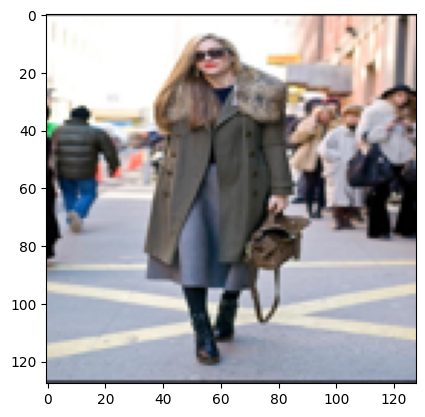

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1])

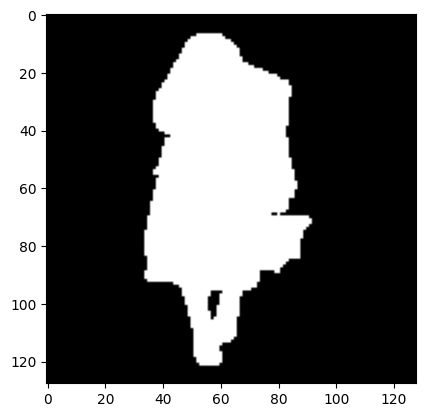

In [ ]:
plt.imshow(y_train[1], cmap = 'gray')

In [ ]:
y_train[0].shape

(128, 128, 1)

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/fashion_dataset/Y_train', 'rb') as f:
#   Y_train = pickle.load(f)

In [ ]:
# #new_img = np.zeros(( IMAGE_HEIGHT, IMAGE_WIDTH), dtype = np.uint8)
# MASK_CHANNELS = 58
# Y_train = np.zeros((len(y_train), IMAGE_HEIGHT, IMAGE_WIDTH, MASK_CHANNELS), dtype = np.bool)
# for n_samples in range(len(y_train)):

#   channels = np.zeros((58, IMAGE_HEIGHT, IMAGE_WIDTH), dtype = np.bool)
#   if n_samples < 5:
#     for x in range(y_train[n_samples].shape[0]):
#       for y in range(y_train[n_samples].shape[1]):
#         for i in range(MASK_CHANNELS):
#           if y_train[n_samples][x][y] == i:
#             channels[i][x][y] = True
#   else:
#     break
#   # plt.imshow(channels[0])
#   # break
#   Y_train[n_samples] = np.stack(channels, axis = 2)


In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, Dropout, MaxPooling2D, concatenate, Conv2DTranspose
from keras import Model

In [ ]:
inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#Contraction Path

In [ ]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation ='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2,2), padding ='same' )(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2,2), padding ='same' )(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2, 2), strides = (2,2), padding ='same' )(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2, 2), strides = (2,2), padding ='same' )(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics ='accuracy')


model.summary()

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_person.h5', verbose = 1, save_best_only=True)

callbacks = [
    # tf.keras.callbacks.Earlystopping(patience=2, monitor ='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir= 'logs')
]

model.fit(X_train, y_train, validation_split = 0.1, batch_size =16, epochs = 25, callbacks =callbacks)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 128, 128, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_87 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_3[0][0]']            
                                                                                                  
 dropout_42 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_87[0][0]']           
                                                                                            

In [ ]:
import pickle
with open('model_pickle', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
import pickle
with open('model_pickle', 'rb') as f:
  model = pickle.load(f)

(128, 128, 3)

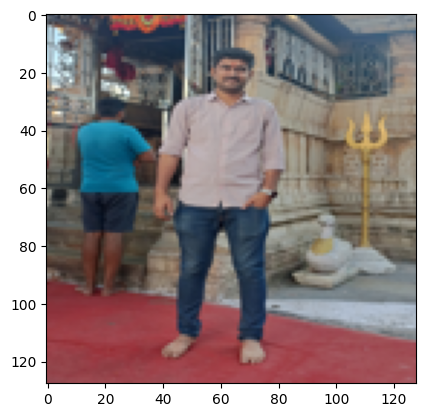

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
test_img = Image.open('/content/IMG20221023081252.jpg')
test_img = test_img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
test_img = np.asarray(test_img)
plt.imshow(test_img)
test_img.shape

(128, 128, 3)

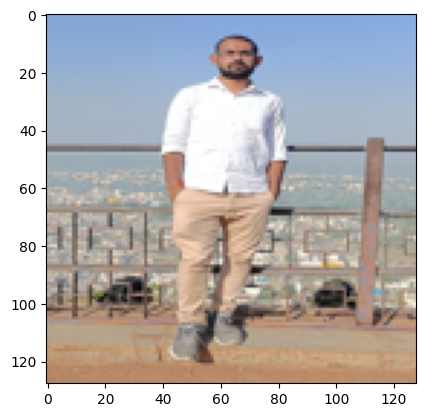

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
test_img = Image.open('/content/IMG20221023085652.jpg')
test_img = test_img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
test_img = np.asarray(test_img)
plt.imshow(test_img)
test_img.shape

In [ ]:
test_img = np.expand_dims(test_img, axis = 0)
test_img.shape

(1, 128, 128, 3)

In [ ]:
result = model.predict(test_img, verbose = 1)

1/1 [==============================] - 0s 39ms/step


In [ ]:
import cv2

In [ ]:
_, mask = cv2.threshold(result[0], 0.5, 1, cv2.THRESH_BINARY)

In [ ]:
mask = mask * 255

In [ ]:
mask1 = np.zeros((128,128,3), dtype = np.uint)
for i in range(3):
  if i == 1:
    mask1[:, :, i] = mask

In [ ]:
overlay = ((0.6 * test_img.squeeze()) + (0.4 *mask1)).astype('uint8')

In [ ]:
def get_bounding_boxes(mask):
  x_min = 128
  y_min = 128
  x_max = 0
  y_max = 0
  for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
      if mask[y][x] > 0:
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_min, y)
  return x_min, y_min, x_max, y_max




In [ ]:
mask.shape
x1, y1, x2, y2 = get_bounding_boxes(mask)


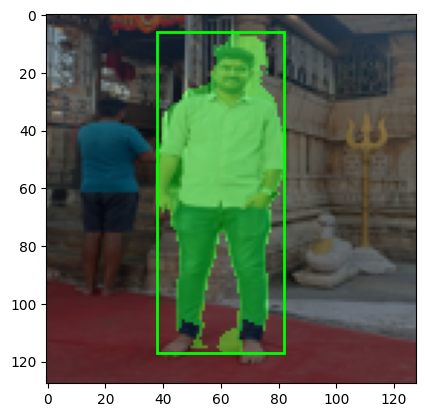

In [ ]:
import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(overlay)

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

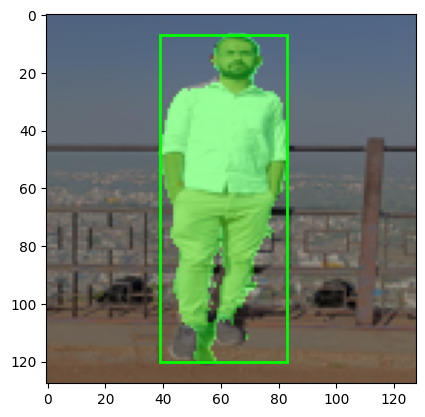

In [ ]:
import matplotlib.patches as patches
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(overlay)

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()